In [1]:
! pip install verde harmonica pandas matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import pandas as pd
import warnings

In [3]:
warnings.filterwarnings('ignore')

Gerando a malha do levantamento com pontos aleatórios

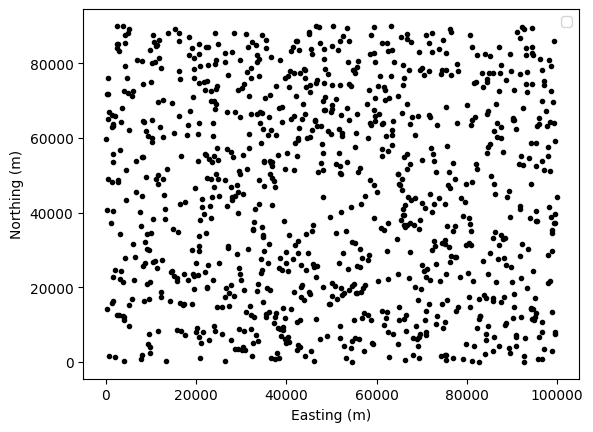

In [4]:
region = [0, 100e3, 0, 90e3]
coordinates = vd.scatter_points(region, size=1000, extra_coords=1000, random_state=123)

plt.plot(coordinates[0], coordinates[1], ".k")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()


Gerando os prismas, com suas densidades, e calculando o efeito gravitacional deles

In [5]:
prismas = [
    [10e3, 15e3, 20e3, 35e3, -1e3,  0],
    [60e3, 80e3, 50e3, 70e3, -2e3,  -0.5e3],
]
densidades = [500, -300]
gz = hm.prism_gravity(coordinates, prismas, densidades, field="g_z")

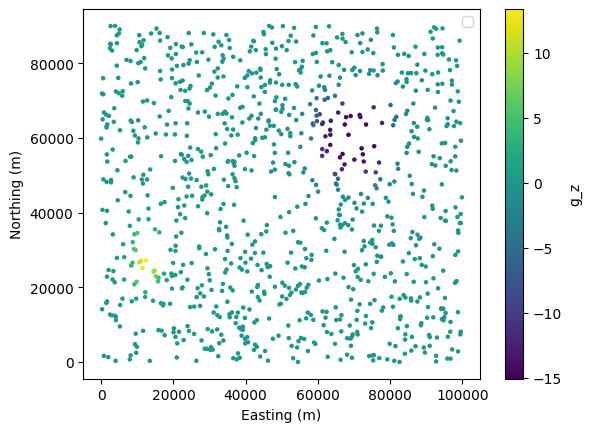

In [6]:
plt.scatter(coordinates[0], coordinates[1], s=5, c=gz)
plt.colorbar(label="g_z")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()

Ajustando um modelo de fontes de equivalentes com damping=1 a uma profundidade de 1000m

In [7]:
fontes = hm.EquivalentSourcesGB(damping=1,depth=1e3)
altura = np.zeros(1000)
fontes.fit([coordinates[0],coordinates[1],altura],data=gz) 

EquivalentSourcesGB(damping=1, depth=1000.0)

Gerando a malha das fontes equivalentes 

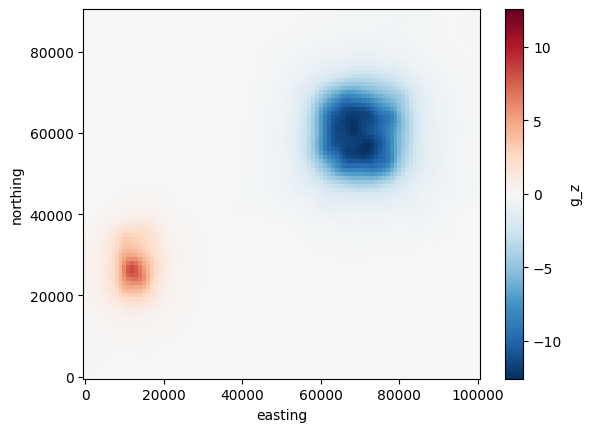

In [8]:
grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=1000)
gz_grid_eq = fontes.grid(grid_coords_eq,data_names="g_z")
gz_grid_eq.g_z.plot()

Gerando uma malha regular equivalente ao levantamento aleatório. 
Quero calcular a diferença entre o levantamento aleatório e a malha regular das fontes equivalentes.
Como a malha das fontes equivalentes é uma malha regular, preciso que a malha do levantamento também seja regular para que a conta seja feita.

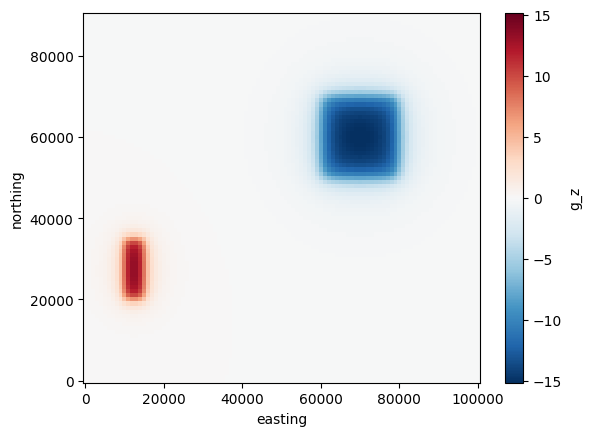

In [9]:
grid_coords = vd.grid_coordinates(region, spacing=1e3, extra_coords=1000)
gz_grid = hm.prism_gravity(grid_coords, prismas, densidades, field="g_z")
grid_true = vd.make_xarray_grid(grid_coords, gz_grid, data_names="g_z", extra_coords_names="upward")
grid_true.g_z.plot()


A diferença calculada abaixo representa o R_2 verdadeiro.

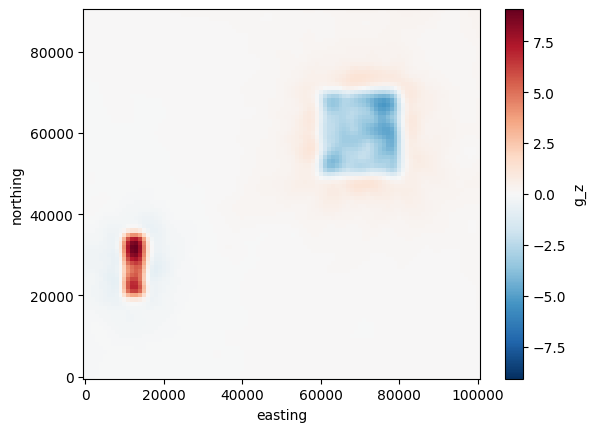

In [10]:
residuo = grid_true - gz_grid_eq
residuo.g_z.plot()

# R_2 verdadeiro

In [11]:
g_z_medio = np.sum(grid_true.g_z.values)/np.size(grid_true.g_z)
residuo_quadrado = np.sum(residuo.g_z.values**2)
R_2_true = 1 - (residuo_quadrado/np.sum([(gz - g_z_medio)**2 for gz in grid_true.g_z.values]))

R_2_true

0.9045672085121063

In [12]:
# Quero achar o numero mais proximo de R_2_true dentro de R_2_block
# E encontrar o n associado a este valor 

def acha_indice(R_2_true,lista):
    "Encontra o valor mais próximo de R_2_true dentro da lista e retorna sua posição dentro dela."
    valores = []
    for element in lista:
        valores.append(np.abs(element-R_2_true))
    indice = valores.index(np.min(valores))
    return indice

Usando validação cruzada para avaliar quão bem o modelo de fontes equivalentes consegue prever com precisão os valores do campo

Validação cruzada sem blocos

In [13]:

R_2_kfold = (
    vd.cross_val_score(
        fontes,
        coordinates,
        gz,
    )
)


In [14]:
print(f"min: {np.min(R_2_kfold)}")
print(f"max: {np.max(R_2_kfold)}")
print(f"mean: {np.mean(R_2_kfold)}")

min: 0.9066216291444976
max: 0.9574467938405484
mean: 0.9400417701588228


Validação cruzada com blocos

In [15]:


R_2_block = (
    vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=500, n_splits=2, shuffle=True, random_state=123),
    )
)


In [16]:
print(f"min: {np.min(R_2_block)}")
print(f"max: {np.max(R_2_block)}")
print(f"mean: {np.mean(R_2_block)}")

min: 0.859460574021668
max: 0.904777818229933
mean: 0.8821191961258005


Variando o número de splits.
Estou pegando a média dos erros para plotar

In [17]:
# Dados são primeiramente agrupados em blocos retangulares de tamanhos fornecimento pelo argumento "spacing".
# Os blocos são então divididos em teste e treinamento iterativamente através dos k folds do dado.
# (k é dado por "n_splits").
R_2_splits_media = [] # Variando o numero de splits
n = np.arange(2,11)
for n_splits in n:
    R_2_splits_media.append(np.mean(
        vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=500, n_splits=n_splits, shuffle=True, random_state=123),
        )
    ))



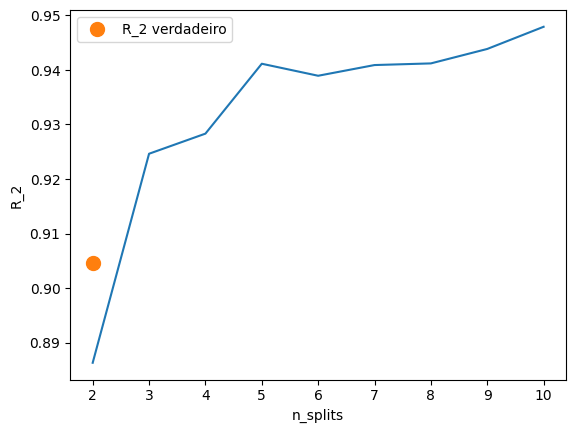

In [18]:
indice = acha_indice(R_2_true,R_2_splits_media)
plt.plot(n,R_2_splits_media)
plt.xlabel("n_splits")
plt.ylabel("R_2")
plt.plot(n[indice],R_2_true,"o",markersize=10,label=f"R_2 verdadeiro")
plt.legend()

Variando tamanho do bloco.
Estou pegando a média dos erros para plotar

In [19]:
R_2_block_media = []
block = np.arange(1000,10950,950) 
nsplits = 5
for spacing in block:
    R_2_block_media.append(np.mean(
        vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=spacing, n_splits=nsplits, shuffle=True, random_state=123),
        )
    ))



Text(0, 0.5, 'R_2')

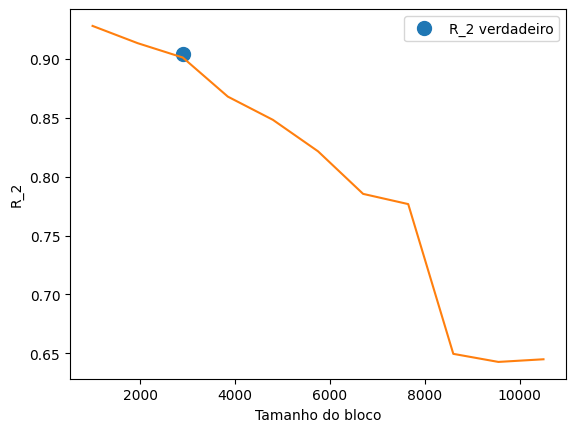

In [20]:
indice = acha_indice(R_2_true,R_2_block_media)
plt.plot(block[indice],R_2_true,"o",markersize=10,label=f"R_2 verdadeiro")
plt.plot(block,R_2_block_media)
plt.legend()
plt.xlabel("Tamanho do bloco")
plt.ylabel("R_2")


(0.0, 4000.0)

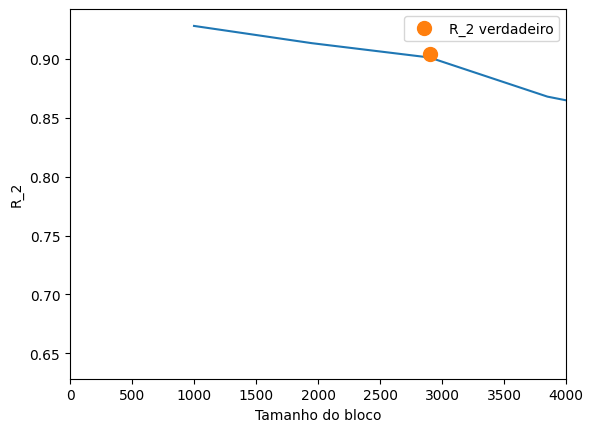

In [21]:
plt.plot(block,R_2_block_media)
plt.plot(block[indice],R_2_true,"o",markersize=10,label=f"R_2 verdadeiro")
plt.legend()
plt.xlabel("Tamanho do bloco")
plt.ylabel("R_2")
plt.xlim(0,4000)

# Colocando blocos nas fontes equivalentes 
(não é o objetivo, só está aqui por curiosidade)

In [22]:
R_2 = []
sources = []

block = [block for block in range(50,102050,2000)]
for block_size in block:
    fontes_block = hm.EquivalentSourcesGB(damping=1,depth=1e3,block_size=block_size, depth_type="constant")
    # These sources were set at a constant depth of 1km bellow the zeroth height and with a damping equal to 1.

    fontes_block.fit([coordinates[0],coordinates[1],altura],data=gz)
    # During this step the point sources are created through the block averaging process.

    # Using cross-validation to evaluate how well
    # these equivalent sources can accurately predict the values of the field
    score = np.mean(
        vd.cross_val_score(
            fontes_block,
            coordinates,
            gz,
        )
    )
    R_2.append(score)
    sources.append(fontes_block.points_[0].size)


Text(0, 0.5, 'Erro')

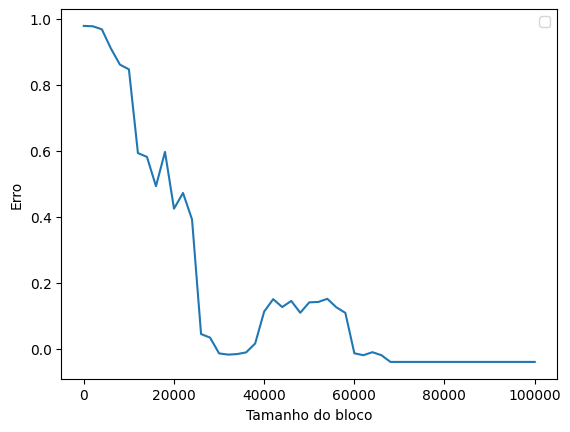

In [23]:
plt.plot(block,R_2)
plt.legend()
plt.xlabel('Tamanho do bloco')
plt.ylabel('Erro')


Text(0, 0.5, 'Numero de fontes')

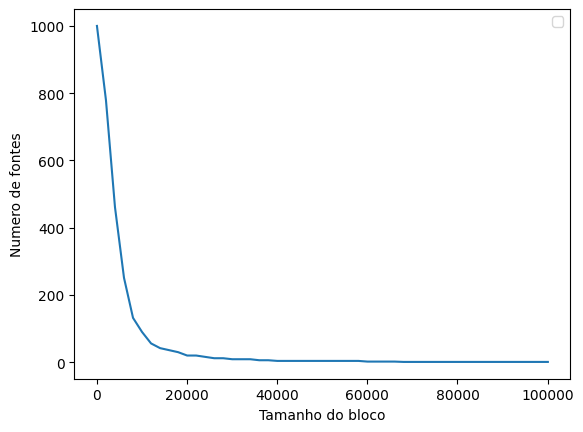

In [24]:
plt.plot(block,sources)
plt.legend()
plt.xlabel('Tamanho do bloco')
plt.ylabel('Numero de fontes')

Text(0, 0.5, 'Erro')

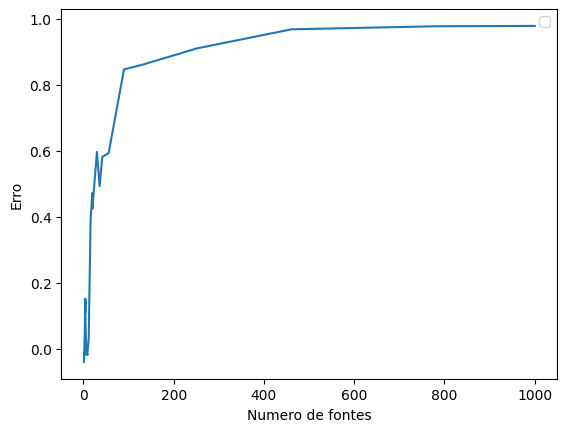

In [25]:
plt.plot(sources,R_2)
plt.legend()
plt.xlabel('Numero de fontes')
plt.ylabel('Erro')

Text(0, 0.5, 'Erro')

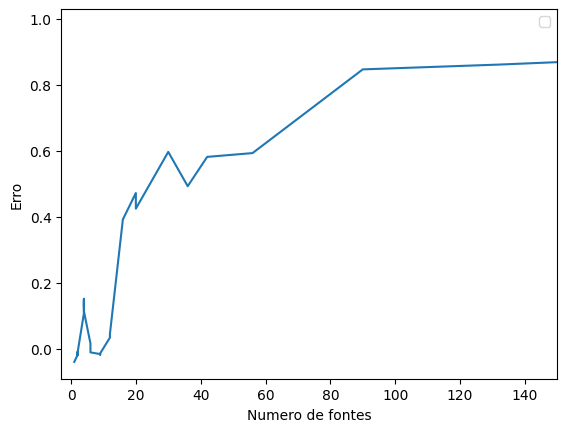

In [26]:
plt.plot(sources,R_2)
plt.legend()
plt.xlabel('Numero de fontes')
plt.xlim(-3,150)
plt.ylabel('Erro')